In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from skimage.restoration import denoise_tv_chambolle

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
MAX_DENSITY_NB = 25
EXT_WIDTH = 100
WIN_WIDTHS = np.arange(20, 100, 2)

colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list).copy()

In [25]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        for checkpoint in range(win_width//2, len(x_pos) - win_width//2):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[1: int(len(xs)/2)+1] - float(xs[1: int(len(xs)/2)+1][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])
            ys1 = ys[1: int(len(ys)/2)+1] - float(ys[1: int(len(ys)/2)+1][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])        

            cum_xs1 = abs(np.cumsum(abs(xs1)))
            cum_xs2 = abs(np.cumsum(abs(xs2)))
            cum_ys1 = abs(np.cumsum(abs(ys1)))
            cum_ys2 = abs(np.cumsum(abs(ys2)))

            xs_max_val = max(np.max(abs(cum_xs1)), np.max(abs(cum_xs2)))
            cum_xs1 = cum_xs1 / xs_max_val
            cum_xs2 = cum_xs2 / xs_max_val

            ys_max_val = max(np.max(abs(cum_ys1)), np.max(abs(cum_ys2)))
            cum_ys1 = cum_ys1 / ys_max_val
            cum_ys2 = cum_ys2 / ys_max_val
            
            vals.append((abs(cum_xs1[-1] - cum_xs2[-1] + cum_ys1[-1] - cum_ys2[-1]))
                        + (max(np.std(xs1), np.std(xs2)) - min(np.std(xs1), np.std(xs2)))
                        + (max(np.std(ys1), np.std(ys2)) - min(np.std(ys1), np.std(ys2))))
                    
        vals = np.concatenate((np.ones(int(win_width/2)) * 0, vals))
        vals = np.concatenate((vals, np.ones(int(win_width/2)) * 0))
        vals = np.array(vals)
        all_vals.append(vals)

    all_vals = np.array(all_vals) + 1e-5
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return all_vals, normalized_vals

In [5]:
def slice_data(signal_seq, jump_d, ext_width, shift_width):
    slice_d = []
    indice = []
    for i in range(ext_width, signal_seq.shape[1] - ext_width, jump_d):
        crop = signal_seq[:, i - shift_width//2: i + shift_width//2]
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice) - ext_width

In [6]:
def climb_mountain(signal, cp, seuil=5):
    while True:
        vals = [signal[x] if 0<=x<signal.shape[0] else -1 for x in range(cp-seuil,cp+1+seuil)]
        if len(vals) == 0:
            return -1
        new_cp = cp + np.argmax(vals) - seuil
        if new_cp == cp:
            return new_cp
        else:
            cp = new_cp

In [7]:
def position_extension(x, y, ext_width):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])[1:]
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])[1:]
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)
    return np.array(datas), delta_prev_data.shape[0], delta_next_data.shape[0]

In [8]:
def sigmoid(x, beta=3):
    x = np.minimum(np.ones_like(x)*0.999, x)
    x = np.maximum(np.ones_like(x)*0.001, x)
    return 1 / (1 + (x / (1-x))**(-beta))

In [9]:
def density_estimation(x, y, ext1, ext2, max_nb):
    densities = []
    dist_amp = 2.0
    local_mean_window_size = 5
    assert max_nb//2 < ext1 and max_nb//2 < ext2
    
    for i in range(x.shape[0]):
        density1 = 0
        density2 = 0
        
        slice_x = x[max(0, i-max_nb//2):i].copy()
        slice_y = y[max(0, i-max_nb//2):i].copy()
        
        if len(slice_x) > 0:
            mean_dist = np.sqrt(uncumulate(slice_x)**2 + uncumulate(slice_y)**2).mean()
            mean_dist *= dist_amp

            slice_x -= slice_x[len(slice_x)//2]
            slice_y -= slice_y[len(slice_y)//2]
            for s_x, s_y in zip(slice_x, slice_y):
                if np.sqrt(s_x**2 + s_y**2) < mean_dist:
                    density1 += 1
    
        slice_x = x[i:min(x.shape[0], i+max_nb//2)].copy()
        slice_y = y[i:min(x.shape[0], i+max_nb//2)].copy()
                
        if len(slice_x) > 0:
            mean_dist = np.sqrt(uncumulate(slice_x)**2 + uncumulate(slice_y)**2).mean()
            mean_dist *= dist_amp

            slice_x -= slice_x[len(slice_x)//2]
            slice_y -= slice_y[len(slice_y)//2]
            for s_x, s_y in zip(slice_x, slice_y):
                if np.sqrt(s_x**2 + s_y**2) < mean_dist:
                    density2 += 1
        densities.append(max(density1, density2))
        
    
    # local_mean
    new_densities = []
    for i in range(len(densities)):
        new_densities.append(np.mean(densities[max(0, i-local_mean_window_size//2): 
                                               min(len(densities), i+local_mean_window_size//2+1)]))
    densities = new_densities
        
    return np.array(densities)

In [10]:
def signal_from_extended_data(x, y, win_widths, ext_width, jump_d, shift_width):
    assert ext_width > shift_width
    
    datas, shape_ext1, shape_ext2 = position_extension(x, y, ext_width)
    signal, norm_signal = make_signal(datas[0], datas[1], win_widths)
    density = density_estimation(datas[0], datas[1], shape_ext1, shape_ext2, max_nb=MAX_DENSITY_NB*2)
    
    denoised_den = denoise_tv_chambolle(density, weight=3, eps=0.0002, max_num_iter=100, channel_axis=None)
    denoised_den = sigmoid(denoised_den / MAX_DENSITY_NB)
    #denoised_den = 1
    
    signal = signal[:,] * denoised_den
    sliced_signals, slice_indice = slice_data(signal, jump_d, shape_ext1, shift_width)
    
    return (signal[:, shape_ext1:signal.shape[1] - shape_ext2],
            sliced_signals,
            slice_indice,
            signal,
            denoised_den,
            shape_ext1, shape_ext2)

In [11]:
def local_roughness(signal, window_size):
    uc_signal = uncumulate(signal)
    uc_signal /= abs(uc_signal)
    counts = []
    for i in range(window_size//2, len(uc_signal) - window_size//2):
        count = 0
        cur_state = 1
        for j in range(i-window_size//2, i+window_size//2):
            new_state = uc_signal[j]
            if new_state != cur_state:
                count += 1
            cur_state = new_state
        counts.append(count)
    counts = np.concatenate(([counts[0]] * (window_size//2), counts))
    counts = np.concatenate((counts, [counts[-1]] * (window_size//2)))
    return counts

In [12]:
def slice_normalize(slices):
    val = np.mean(np.sum(slices, axis=(2)).T, axis=0)
    val = val - np.min(val)
    val = val / np.max(val)
    return val

In [89]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=None,
                                                        T=500,
                                                        alphas=[0.5, 1.5],
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
changepoints = changepoints[:-1]

GT: [ 73 219 253 381 431 433 491]


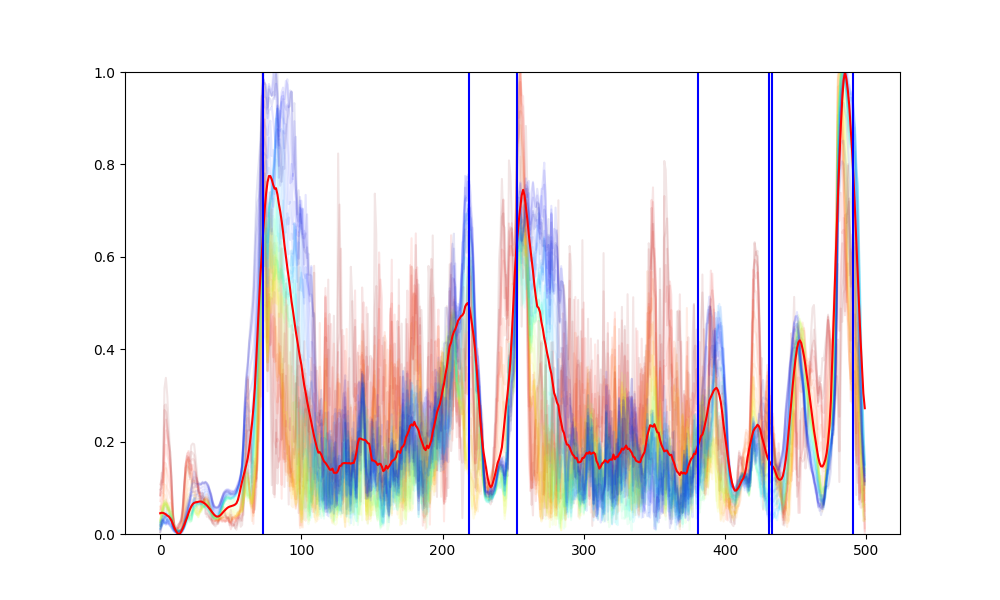

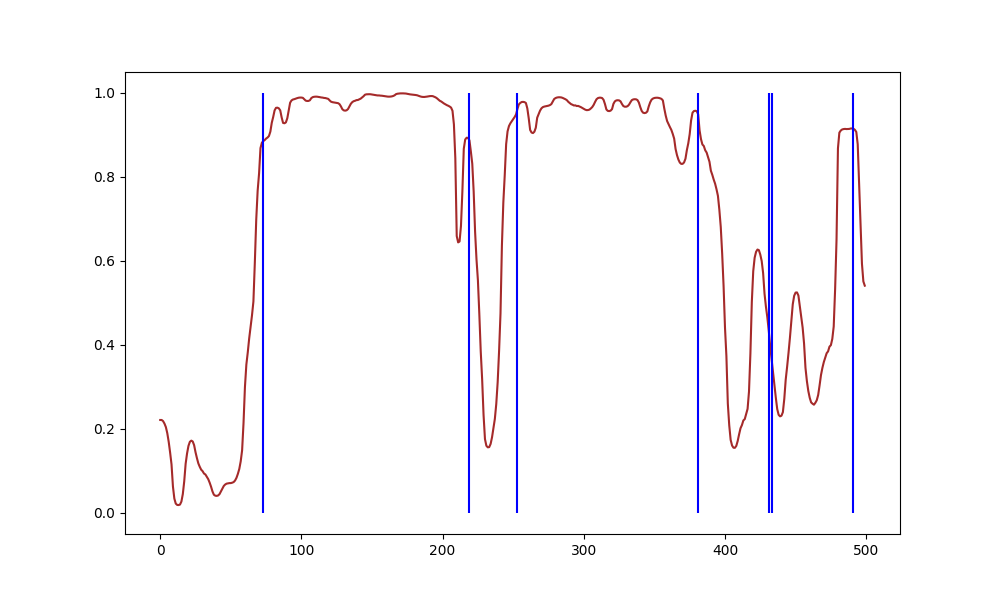

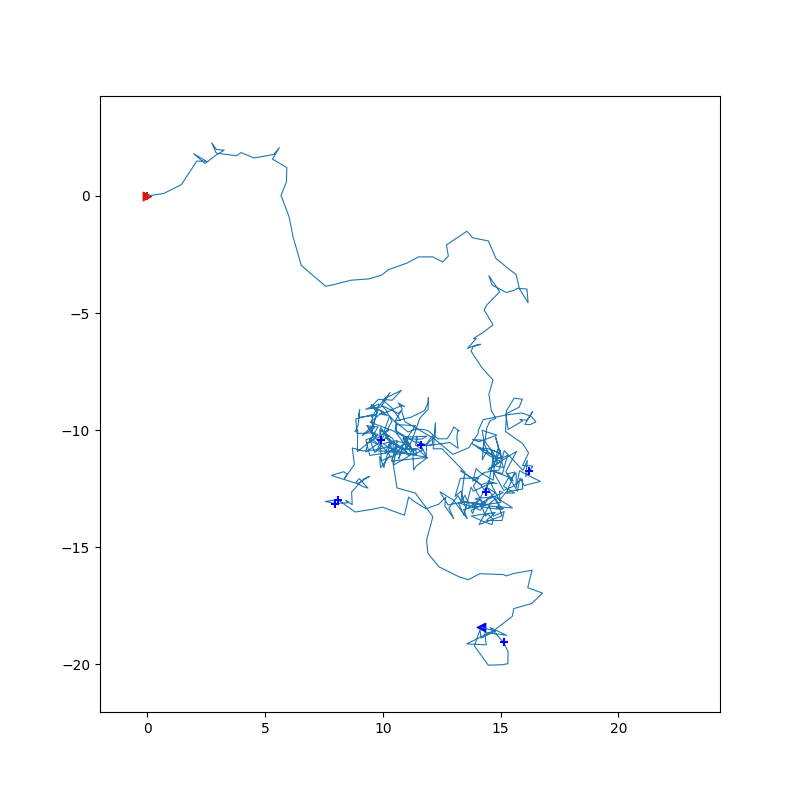

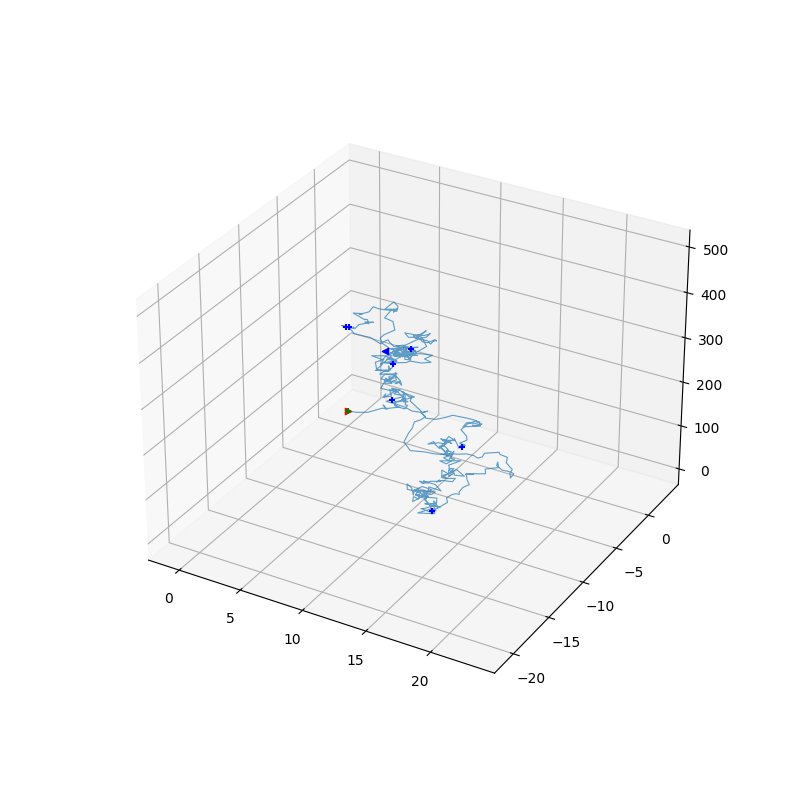

In [90]:
print(f'GT: {changepoints}')


checkpoints = [0]

signals, sliced_signals, _, _, denoised_density, l_ext,_ = signal_from_extended_data(x, y,
                                                                            WIN_WIDTHS,
                                                                            EXT_WIDTH,
                                                                            1,
                                                                            10)
slice_norm_signal = slice_normalize(sliced_signals)

plt.figure(figsize=(10, 6))
for i in range(signals.shape[0]):
    plt.plot(np.arange(signals.shape[1]), signals[i] / np.max(signals[i]), alpha=0.1,
             c=color_seq[int(i * 255 / signals.shape[0])])
plt.plot(np.arange(signals.shape[1]), slice_norm_signal, c='red')
for cp in changepoints:
    plt.vlines(cp, 0, 1, color='blue')
plt.ylim([0, 1])

if not isinstance(denoised_density, int):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(signals.shape[1]), denoised_density[l_ext:l_ext + signals.shape[1]], c='brown')
    for cp in changepoints:
        plt.vlines(cp, 0, 1, color='blue')

#############################################################################

plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
for checkpoint in checkpoints:
    plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in changepoints:
    plt.scatter(x[cp], y[cp], marker='+', c='blue', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')

for cp in changepoints:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='blue', zorder=2)
for checkpoint in checkpoints:
    ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

In [66]:
def signal_comparison(x_pos, y_pos, win_widths, ext_width, checkpoint1, checkpoint2):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        
        xs1 = x_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        ys1 = y_pos[ext_width + checkpoint1 - int(win_width/2) : ext_width + checkpoint1 + int(win_width/2)]
        
        xs2 = x_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        ys2 = y_pos[ext_width + checkpoint2 - int(win_width/2) : ext_width + checkpoint2 + int(win_width/2)]
        
        xs1_l = xs1[1: int(len(xs1)/2)+1] - float(xs1[1: int(len(xs1)/2)+1][0])
        xs1_r = xs1[int(len(xs1)/2):] - float(xs1[int(len(xs1)/2):][0])

        ys1_l = ys1[1: int(len(ys1)/2)+1] - float(ys1[1: int(len(ys1)/2)+1][0])
        ys1_r = ys1[int(len(ys1)/2):] - float(ys1[int(len(ys1)/2):][0])
        
        xs2_l = xs2[1: int(len(xs2)/2)+1] - float(xs2[1: int(len(xs2)/2)+1][0])
        xs2_r = xs2[int(len(xs2)/2):] - float(xs2[int(len(xs2)/2):][0])

        ys2_l = ys2[1: int(len(ys2)/2)+1] - float(ys2[1: int(len(ys2)/2)+1][0])
        ys2_r = ys2[int(len(ys2)/2):] - float(ys2[int(len(ys2)/2):][0])
        
        
        xs1_l = np.cumsum(abs(xs1_l))
        xs1_r = np.cumsum(abs(xs1_r))
        ys1_l = np.cumsum(abs(ys1_l))
        ys1_r = np.cumsum(abs(ys1_r))
        xs2_l = np.cumsum(abs(xs2_l))
        xs2_r = np.cumsum(abs(xs2_r))
        ys2_l = np.cumsum(abs(ys2_l))
        ys2_r = np.cumsum(abs(ys2_r))

        #xs1_l, xs1_r, ys1_l, ys1_r
        #xs2_l, xs2_r, ys2_l, ys2_r
        comb = [[[xs1_l, xs2_r], [ys1_l, ys2_r]], [[xs1_r, xs2_r], [ys1_r, ys2_r]],
               [[xs1_l, xs2_l], [ys1_l, ys2_l]], [[xs1_r, xs2_l], [ys1_r, ys2_l]]]
                 
        for cb in comb:
            tmp_vals = []
            for s in cb:
                l, r = s[0], s[1]
                max_val = max(np.max(abs(l)), np.max(abs(r)))
                l_val = l / max_val
                r_val = r / max_val
                tmp_vals.append(l_val)
                tmp_vals.append(r_val)
            vals.append(abs(tmp_vals[0][-1] - tmp_vals[1][-1] + tmp_vals[2][-1] - tmp_vals[3][-1]))
        vals = np.array(vals)

        all_vals.append(vals)
    all_vals = np.array(all_vals)
    mean_vals = np.sort(all_vals.T, axis=1)[:, int(len(win_widths) * 0.25): int(len(win_widths) * 0.75)].mean(axis=1)

    if (mean_vals[1] + mean_vals[2]) / 2 >= 1 and (mean_vals[0] + mean_vals[3]) / 2 < 1 and mean_vals[1] > 1 and mean_vals[2] > 1:
        return 1
    elif (mean_vals[1] + mean_vals[2]) / 2 < 1. and (mean_vals[0] + mean_vals[3]) / 2 >= 1 and mean_vals[0] > 1 and mean_vals[3] > 1:
        return -1
    else:
        return 0

In [67]:
def check_pts_mat(checkpoints, x, y, win_widths, ext_width):
    cp_mat = np.zeros((len(checkpoints), len(checkpoints))).astype(int) - 1
    datas, _, _ = position_extension(x, y, ext_width)
    for i in range(cp_mat.shape[0]):
        for j in range(cp_mat.shape[1]):
            gap = abs(checkpoints[i] - checkpoints[j]) * 2
            gap = min(gap, 100)
            if i == j:
                gap = 30
            local_win_widths = np.arange(gap, gap+30, 2)
            cp_mat[i][j] = signal_comparison(datas[0], datas[1],
                                             win_widths, ext_width,
                                             checkpoints[i], checkpoints[j])
    
    return cp_mat

In [84]:
print(f'GT: {changepoints}')

xa = []
for det_cp in np.where(slice_norm_signal > 0.2)[0]:
    xa.append(climb_mountain(slice_norm_signal, det_cp, seuil=5))
xa = np.unique(xa)

print(xa)
print(xa[np.argsort(slice_norm_signal[xa])[::-1]])
check_arange = WIN_WIDTHS

GT: [ 64  86 105 287 473]
[ 65  84 113 296 330 481]
[481  65 113 296  84 330]


[[-1  0  1  0  0  0  0  1 -1]
 [ 0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0 -1  0 -1  1]
 [-1  0  0  0  0  0  0  1 -1]]


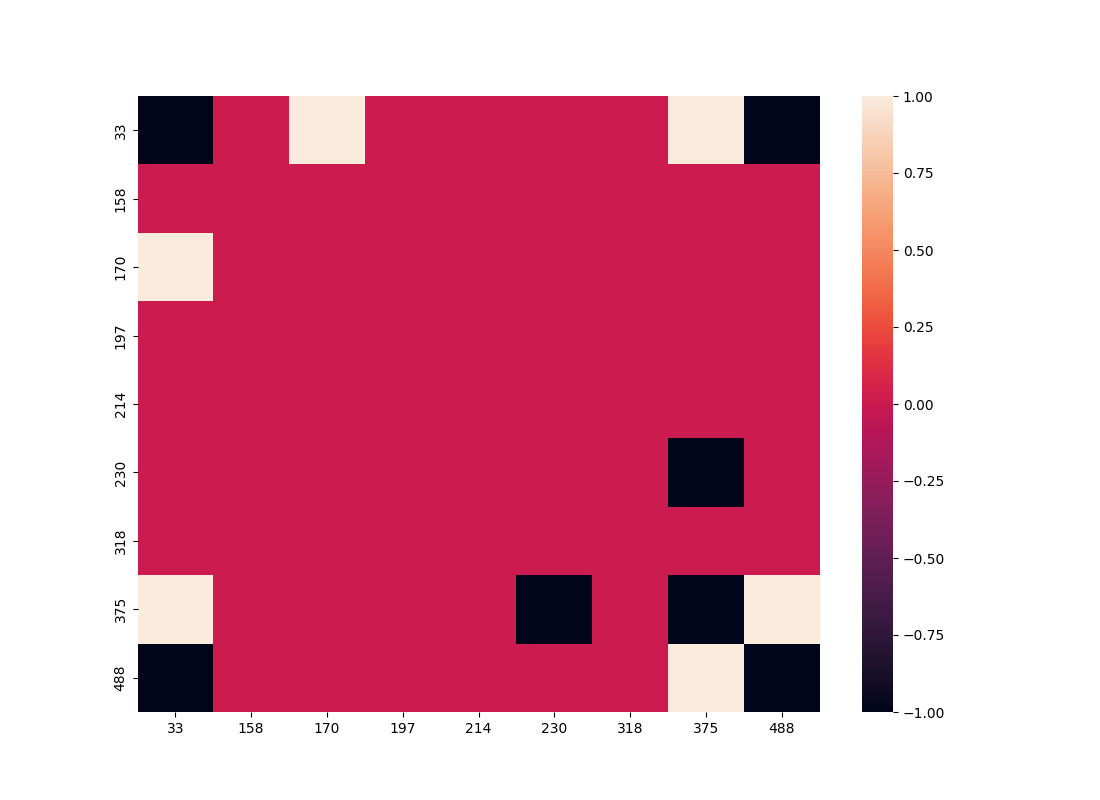

In [81]:
cor_mat = check_pts_mat(xa, x, y,
                        check_arange, ext_width=EXT_WIDTH)
print(cor_mat)
plt.figure(figsize = (11,8))
sns.heatmap(cor_mat, xticklabels=xa, yticklabels=xa)
plt.show()